In [2]:
using Distributions
using Plots
#using PGFPlotsX
using LaTeXStrings
using LinearAlgebra
using Colors
using JLD
using Parameters
using Random
#pgfplotsx()
#push!(PGFPlotsX.CUSTOM_PREAMBLE, raw"\usepgfplotslibrary{fillbetween}");

In [3]:
T = 80
n_steps = 50
gridman = LinRange(0, 1, n_steps)
;

### Heatmap example

In [4]:
experiment = JLD.load("experiment.jld")


Dict{String, Any} with 6 entries:
  "efe_grids"  => Any[19.9776, 20.0538, 20.1301, 20.2064, 20.2823, 20.3576, 20.…
  "points"     => [0.528234 0.0 … 0.795918 0.77551; 0.543932 0.0 … 0.22449 0.22…
  "inst_grids" => Any[19.7641, 19.8398, 19.9157, 19.9915, 20.067, 20.1418, 20.2…
  "responses"  => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.…
  "idxs"       => Any[CartesianIndex(1, 1), CartesianIndex(50, 50), CartesianIn…
  "epi_grids"  => Any[0.213498, 0.213928, 0.214377, 0.214845, 0.215328, 0.21582…

In [5]:
efe_grids = experiment["efe_grids"]
efe_grids = reshape(efe_grids, n_steps,n_steps, T);
efe_grids[efe_grids .== Inf] .= maximum(efe_grids[efe_grids .!= Inf])

epi_grids = experiment["epi_grids"]
epi_grids = reshape(epi_grids, n_steps,n_steps, T);

inst_grids = experiment["inst_grids"]
inst_grids = reshape(inst_grids, n_steps,n_steps, T);

idxs = experiment["idxs"]
points = experiment["points"]
;

In [6]:
efe_grids[:,:,end][idxs[end]]

1.000001847584209

In [7]:
index = 80
x = y = gridman

target = [[0.8], [0.2]]
current = map(x -> [first(x)], points[:,index])


axis1 = @pgf Axis(
    {
        title="EFE landscape at time $(index)",
        xlabel=L"g_s",
        ylabel=L"g_n",
        zlabel="hz",
        legend_pos = "north east",
        legend_cell_align="{left}",
        grid = "major",
        view = (0, 90),
        colorbar,
        "colormap/hot",
        colorbar_style={"xlabel=EFE, xticklabel pos=upper"}
    },
    Plot({only_marks, color="green", mark_size=3.0, mark="*"}, 
    Coordinates(target...)), LegendEntry("Target"),
    Plot({only_marks, color="black", mark_size=3.0, mark="*"}, 
    Coordinates(current...)), LegendEntry("Current"),
    Plot3(
        {
            surf,
            shader = "flat",
        },
        Coordinates(x, y, efe_grids[:, :, index]))
    )
#pgfsave("viz/heatmap_$(index).pdf", axis1)
#pgfsave("tikz/heatmap_$(index).tikz", axis1)

LoadError: LoadError: UndefVarError: @pgf not defined
in expression starting at In[7]:8

In [8]:
#pgfsave("viz/heatmap_$(index).pdf", axis1)
#pgfsave("tikz/heatmap_$(index).tikz", axis1)

### Time-series plots example

In [9]:
# Get the values of queried points for all time steps
epi_mins = [epi_grids[:,:,i][idxs[i]] for i in 1:T]
inst_mins = [inst_grids[:,:,i][idxs[i]] for i in 1:T]

# Get rid of infs for inhibition of return
epi_means = [mean(epi_grids[:,:,i][isfinite.(epi_grids[:,:,i])]) for i in 1:T]
inst_means = [mean(inst_grids[:,:,i][isfinite.(inst_grids[:,:,i])]) for i in 1:T]
;

In [10]:
plt_agent = @pgf GroupPlot(
    # group plot options
    {
        width="15cm", height="8cm",

        group_style = {
            group_size = "2 by 1",
            horizontal_sep = "1.5cm",
        },
    },
    # first
    {xlabel=L"t",
           ylabel="value",
           legend_pos = "north east",
           legend_cell_align="{left}",
           grid = "major",
        #    title="TODO: TITLE",
           legend_style = "{nodes={scale=0.8, transform shape}}",
    },
    Plot(
        {no_marks,color="blue"}, Coordinates(collect(1:T), epi_mins)
    ), LegendEntry("Epistemic value"),
    # second
    {xlabel=L"t",
           legend_pos = "south east",
           legend_cell_align="{left}",
           grid = "major",
        #    title="Dataset $(index)",
           legend_style = "{nodes={scale=0.8, transform shape}}",
    },
    Plot(
        {no_marks,color="blue"}, Coordinates(collect(1:T), inst_mins)
    ), LegendEntry("Instrumental value"),
)

#pgfsave("viz/grouped_agent.pdf", plt_agent)
#pgfsave("tikz/grouped_agent.tikz", plt_agent)

LoadError: LoadError: UndefVarError: @pgf not defined
in expression starting at In[10]:1

In [11]:
# Plot of user pref function
include("../../src/environment/user.jl")
n_ticks = 100 # How finely to grid the preference function

x = y = LinRange(0,1,n_ticks)

z = zeros(n_ticks,n_ticks);
for i in 1:n_ticks
    for j in 1:100
	z[i,j] = generate_user_response([i/n_ticks,j/n_ticks],binary=false)
    end
end;

pref_map= @pgf Axis(
    {
        title="User preference function)",
        xlabel=L"g_s",
        ylabel=L"g_n",
        zlabel="hz",
        legend_pos = "north east",
        legend_cell_align="{left}",
        grid = "major",
        view = (0, 90),
        colorbar,
        "colormap/hot",
        colorbar_style={"xlabel=θ, xticklabel pos=upper"}
    },
    Plot3(
        {
            surf,
            shader = "flat",
        },
        Coordinates(x, y, z))
    )

LoadError: LoadError: UndefVarError: @pgf not defined
in expression starting at In[11]:14

In [12]:
pgfsave("viz/pref_map.pdf", pref_map)
pgfsave("tikz/pref_map.tikz", pref_map)

LoadError: UndefVarError: pgfsave not defined

### Batch Plots

In [13]:
using Colors
experiment_1 = JLD.load("batch_experiment_1.jld")
experiment_2 = JLD.load("batch_experiment_2.jld")
# experiment_3 = JLD.load("batch_experiment_3.jld") This round got unlucky....

# Heatmap of positive user appraisals
responses_1 = experiment_1["responses"]
responses_2 = experiment_2["responses"]
#responses_3 = experiment_3["responses"]
resp = vcat(responses_1,responses_2)#,responses_3)
#heatmap(resp,legend=false,xlabel="Time step",ylabel="Agent number",title="Simulated user responses")


# Histogram of first index of positive response
idxs = [findfirst( isequal(1),resp[i,:]) for i in 1:size(resp)[1]]
idxs[isnothing.(idxs)] .= 82 # If the agent didn't get a thumbsup, set it to aft;

In [14]:
y = 1:T 
x = 1:T+1

#td = TikzDocument()
#push_preamble!(td,(cmap,Colors.colormap("Grays")))

resp_map= @pgf Axis(
    {
        title="Positive Appraisals)",
        xlabel="Time Index",
        ylabel="Agent number",
        grid = "minor",
        view = (0, 90), 
        colormap = "{blackwhite}{color=(black) color=(yellow)}"
    },
    Plot3(
        {
            scatter,
        },
        Coordinates(x, y, resp')),
    )


LoadError: LoadError: UndefVarError: @pgf not defined
in expression starting at In[14]:7

In [15]:
pgfsave("viz/resp_map.pdf", resp_map)
pgfsave("tikz/resp_map.tikz", resp_map)

LoadError: UndefVarError: pgfsave not defined

In [16]:
uni_idxs = sort(unique(idxs))
bin_heights = map(y -> count(x -> isequal(x,y),idxs),uni_idxs)


32-element Vector{Int64}:
  2
  4
  5
 11
  4
  1
  2
  1
  3
  1
  3
  1
  1
  ⋮
  1
  1
  1
  1
  1
  2
  1
  1
  1
  1
  2
 16

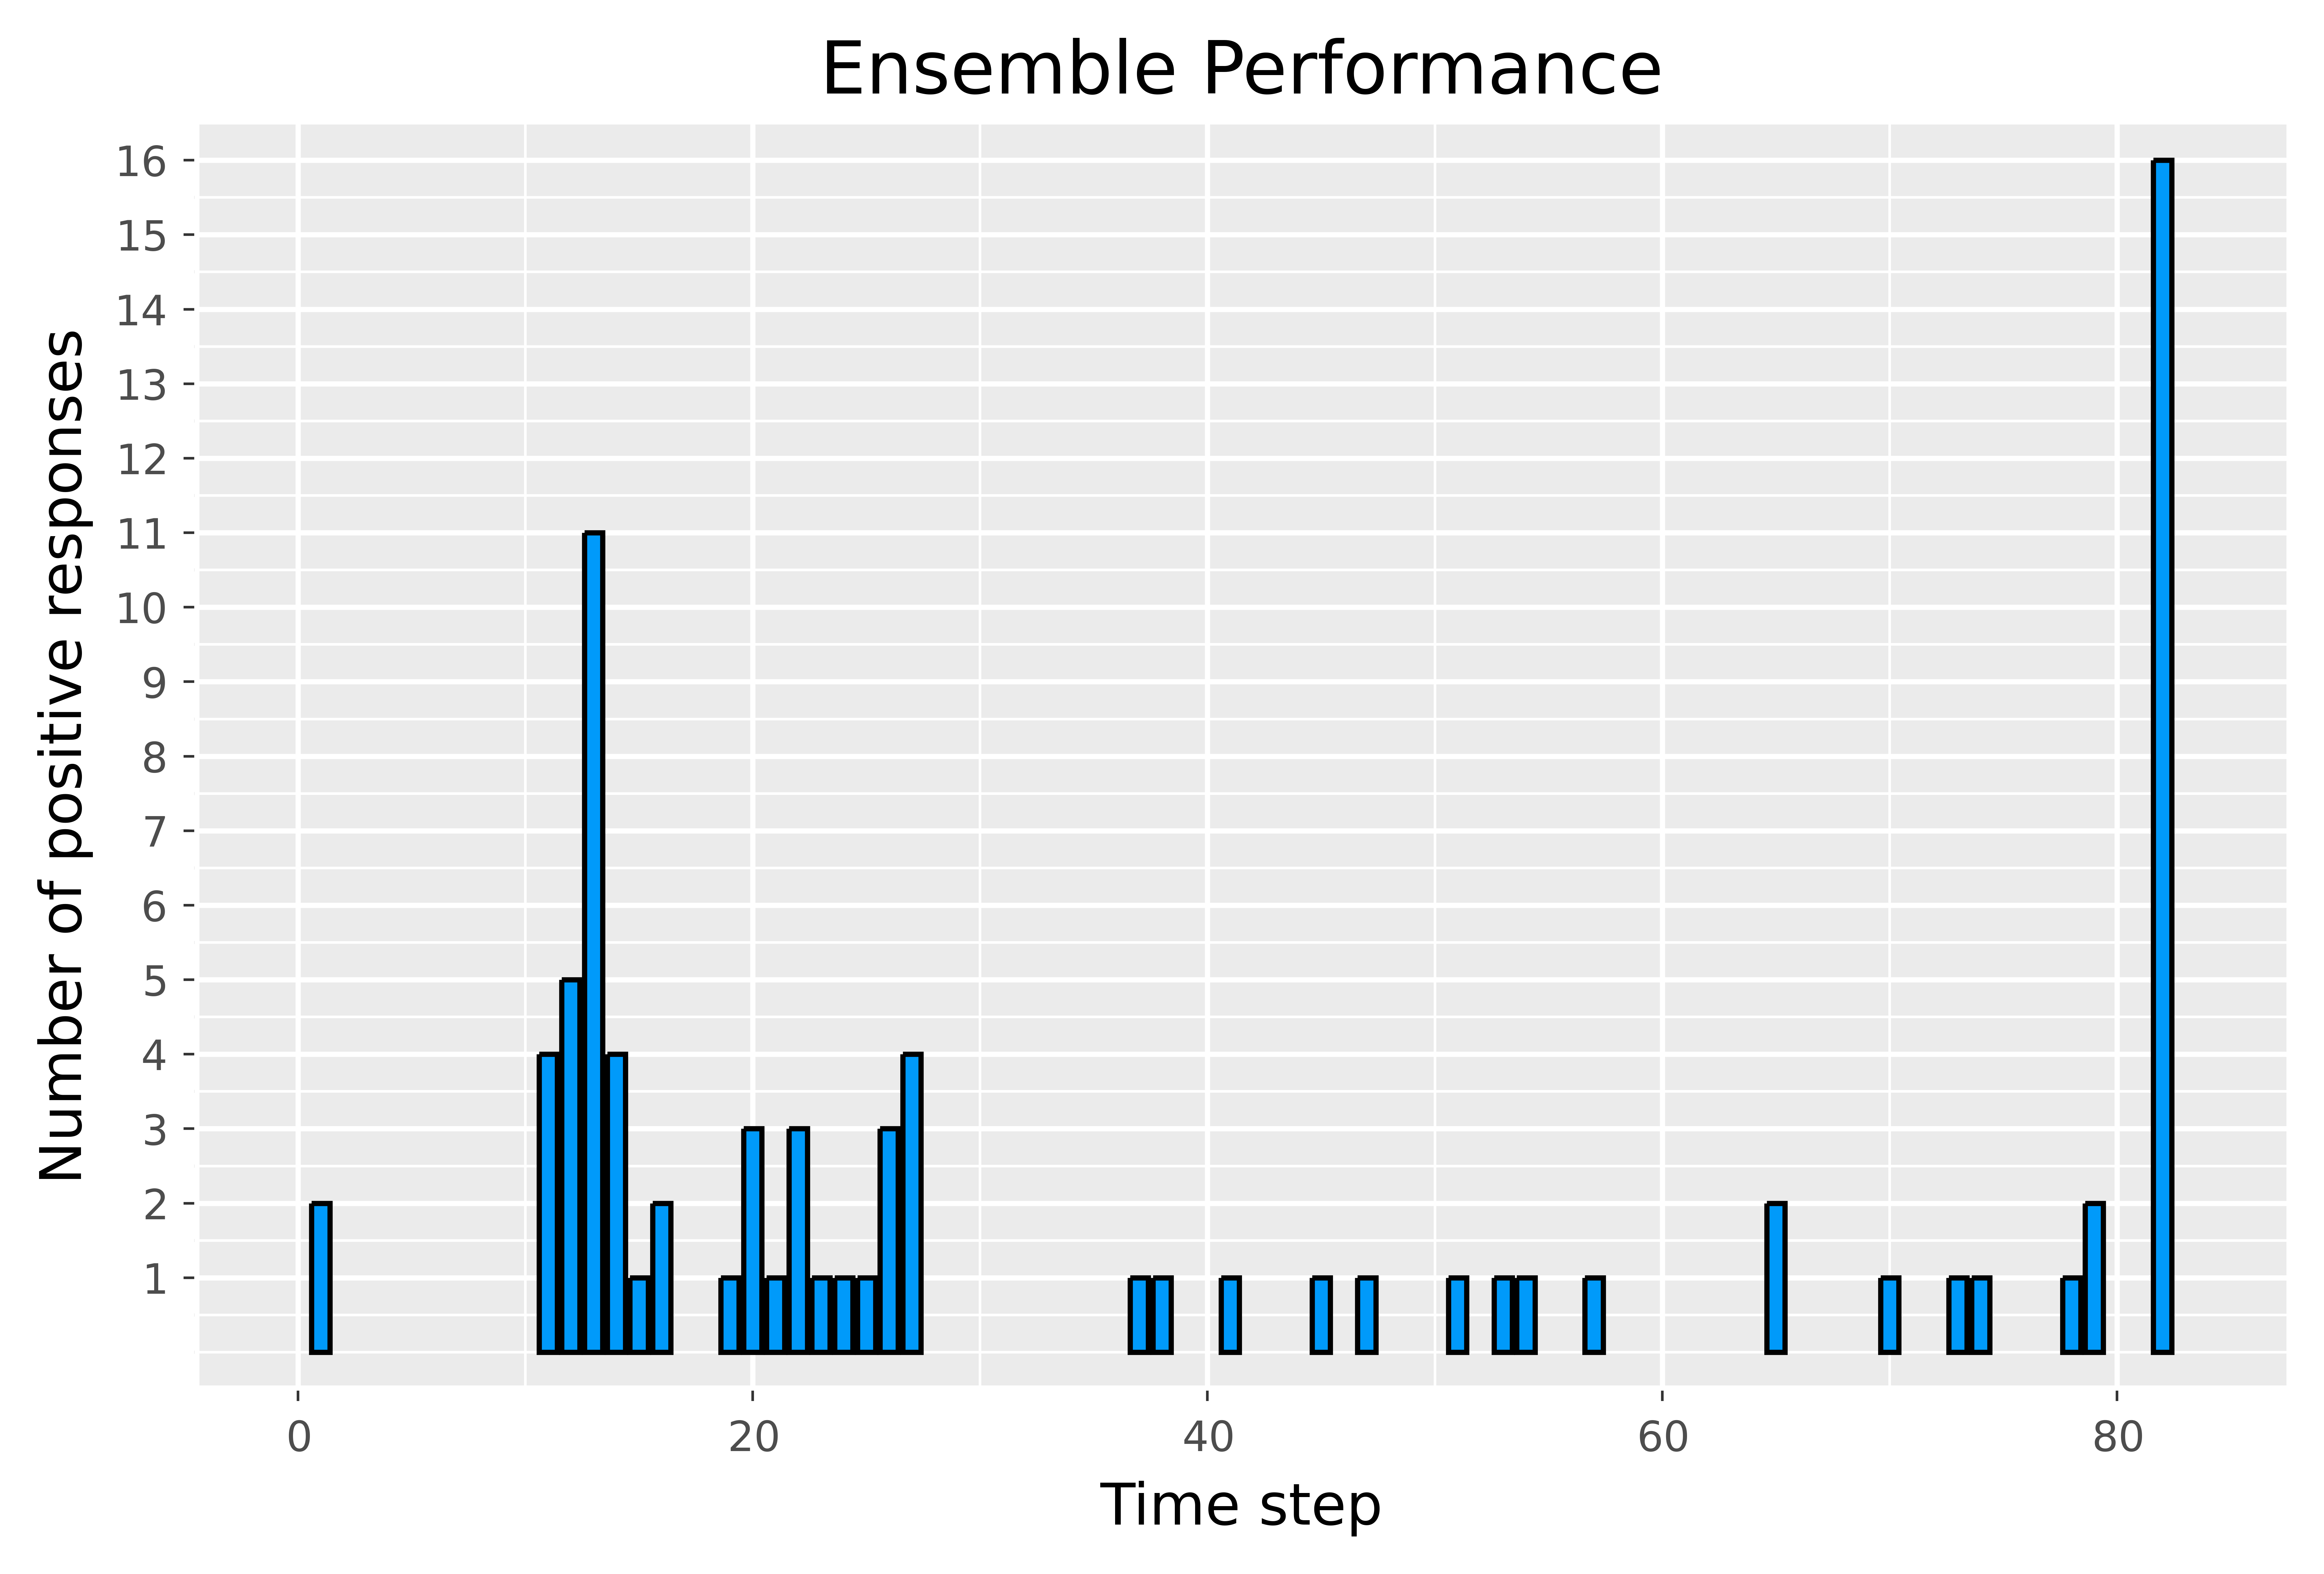

In [25]:
pyplot()
theme(:ggplot2)
resp_bar=bar(uni_idxs,bin_heights,legend=false,xlabel="Time step",ylabel="Number of positive responses",yticks = 1:18,title="Ensemble Performance",dpi=1200)
savefig(resp_bar,"viz/ensemble_perf.png")

In [18]:
?savefig

search: savefig StackOverflowError



```
savefig([plot,] filename)
```

Save a Plot (the current plot if `plot` is not passed) to file. The file type is inferred from the file extension. All backends support png and pdf file types, some also support svg, ps, eps, html and tex.


In [19]:
resp_map= @pgf Axis(
    {
        title="Positive Appraisals",
        xlabel="Time Index",
        grid = "major",
        view = (0, 90), 
        colormap = "{blackwhite}{color=(black) color=(yellow)}",
     xmax = 100
    },
    Plot(
        {
            ybar,
            ybar_interval = 0.,
            enlargelimits =0.05,
            #nodes_near_coords,
            #nodes_near_coords_align={vertical}
        },
        Coordinates(uni_idxs, bin_heights)),
    )


LoadError: LoadError: UndefVarError: @pgf not defined
in expression starting at In[19]:1

In [20]:
?yticks

search: yticks yticks!



```
yticks(p::Plot)
```

returns a vector of the y-axis ticks of the subplots of `p`.

Example use:

```jldoctest
julia> p = plot(1:5, yticks=[1,2])

julia> yticks(p)
1-element Vector{Tuple{Vector{Float64}, Vector{String}}}:
 ([1.0, 2.0], ["1", "2"])
```

If `p` consists of a single subplot, you might want to grab only the first element, via

```jldoctest
julia> yticks(p)[1]
([1.0, 2.0], ["1", "2"])
```

or you can call yticks on the first (only) subplot of `p` via

```jldoctest
julia> yticks(p[1])
([1.0, 2.0], ["1", "2"])
```

---

```
yticks(sp::Subplot)
```

returns the y-axis ticks of the subplot `sp`.

Note that the ticks are returned as tuples of values and labels:

```jldoctest
julia> sp = plot(1:5, yticks=[1,2]).subplots[1]
Subplot{1}

julia> yticks(sp)
([1.0, 2.0], ["1", "2"])
```


In [21]:
?PGFPlotsX.@pgf

UndefVarError: UndefVarError: PGFPlotsX not defined